<a href="https://colab.research.google.com/github/adnan119/EasyOCR-Implementation/blob/master/DeepLearningOCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [2]:
(emnist_train,emnist_test), emnist_info = tfds.load("emnist",
    split=['train','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteTOXY2A/emnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/emnist/byclass/3.0.0.incompleteTOXY2A/emnist-test.tfrecord


Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/byclass/3.0.0. Subsequent calls will reuse this data.


In [3]:
emnist_train

<DatasetV1Adapter shapes: ((28, 28, 1), ()), types: (tf.uint8, tf.int64)>

(28, 28, 1) 14


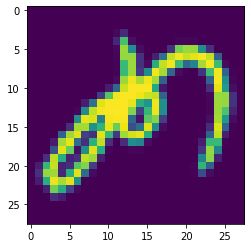

In [4]:
def plot_features(features,transpose=False):
  
  for image, label in features:
    print(image.shape, label.numpy())

  image = image[...,0]

  if transpose:
    image = tf.transpose(image)
  plt.imshow(image)

plot_features(emnist_train.take(1))

(28, 28, 1) 6


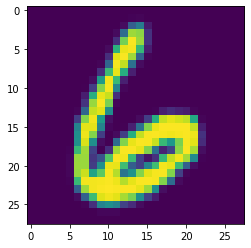

In [5]:
plot_features(emnist_train.take(1),transpose=True)

In [6]:
for image, label in emnist_train.take(5):  # example is (image, label)
  print(image.shape, label.numpy())

(28, 28, 1) 1
(28, 28, 1) 43
(28, 28, 1) 6
(28, 28, 1) 0
(28, 28, 1) 40


In [7]:
def preprocess_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  image = image[...,0]
  image = tf.transpose(image)
  image = tf.reshape(image,[28,28,1])
  return tf.cast(image, tf.float32) / 255., label

In [8]:
emnist_train = emnist_train.map(
    preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
emnist_train = emnist_train.cache()
emnist_train = emnist_train.shuffle(emnist_info.splits['train'].num_examples)
emnist_train = emnist_train.batch(128)
emnist_train = emnist_train.prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
emnist_test = emnist_test.map(
    preprocess_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
emnist_test = emnist_test.batch(128)
emnist_test = emnist_test.cache()
emnist_test = emnist_test.prefetch(tf.data.experimental.AUTOTUNE)


In [11]:
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

In [12]:
model = tf.keras.Sequential([ 
    tf.keras.layers.Conv2D(16, 2, activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(32, 2, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, 2, activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, 2, activation='relu'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(62,activation='softmax')
])


In [13]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 64)          1

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

MCP = ModelCheckpoint('model_3.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
#ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,restore_best_weights = True,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.001)

In [15]:
history = model.fit(emnist_train, epochs=20,validation_data=emnist_test,callbacks=[MCP,RLP])

Epoch 1/20
   5453/Unknown - 19s 3ms/step - loss: 0.7037 - accuracy: 0.7708
Epoch 00001: val_accuracy improved from -inf to 0.82402, saving model to model_3.h5
5453/5453 [==============================] - 37s 7ms/step - loss: 0.7037 - accuracy: 0.7708 - val_loss: 0.5036 - val_accuracy: 0.8240
Epoch 2/20
5447/5453 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.8307
Epoch 00002: val_accuracy improved from 0.82402 to 0.83603, saving model to model_3.h5
5453/5453 [==============================] - 21s 4ms/step - loss: 0.4819 - accuracy: 0.8307 - val_loss: 0.4570 - val_accuracy: 0.8360
Epoch 3/20
5451/5453 [============================>.] - ETA: 0s - loss: 0.4482 - accuracy: 0.8401
Epoch 00003: val_accuracy improved from 0.83603 to 0.84799, saving model to model_3.h5
5453/5453 [==============================] - 21s 4ms/step - loss: 0.4482 - accuracy: 0.8401 - val_loss: 0.4186 - val_accuracy: 0.8480
Epoch 4/20
5439/5453 [============================>.] - ETA: 0s - lo

Text(0, 0.5, 'Accuray')

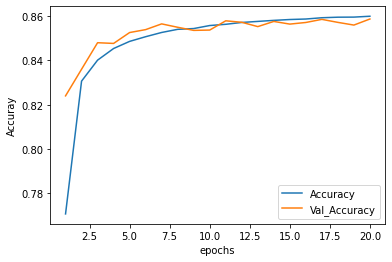

In [16]:
import seaborn as sns

q = len(history.history['accuracy'])

plt.figsize=(10,10)
sns.lineplot(x = range(1,1+q),y = history.history['accuracy'], label='Accuracy')
sns.lineplot(x = range(1,1+q),y = history.history['val_accuracy'], label='Val_Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuray')


In [17]:
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2

In [21]:
%cd /content/drive/My\ Drive/

/content/drive/My Drive


In [22]:
model = load_model('/content/model_3.h5')

In [27]:
# load the input image from disk, convert it to grayscale, and blur
# it to reduce noise
image = cv2.imread('HWocr.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(blurred, 30, 150)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of contour bounding boxes and associated
# characters that we'll be OCR'ing
chars = []

In [28]:
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# filter out bounding boxes, ensuring they are neither too small
	# nor too large
	if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
		# extract the character and threshold it to make the character
		# appear as *white* (foreground) on a *black* background, then
		# grab the width and height of the thresholded image
		roi = gray[y:y + h, x:x + w]
		thresh = cv2.threshold(roi, 0, 255,
			cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
		(tH, tW) = thresh.shape
		# if the width is greater than the height, resize along the
		# width dimension
		if tW > tH:
			thresh = imutils.resize(thresh, width=28)
		# otherwise, resize along the height
		else:
			thresh = imutils.resize(thresh, height=28)
   
    # re-grab the image dimensions (now that its been resized)
		# and then determine how much we need to pad the width and
		# height such that our image will be 32x32
		(tH, tW) = thresh.shape
		dX = int(max(0, 28 - tW) / 2.0)
		dY = int(max(0, 28 - tH) / 2.0)
		# pad the image and force 32x32 dimensions
		padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
			left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
			value=(0, 0, 0))
		padded = cv2.resize(padded, (28, 28))
		# prepare the padded image for classification via our
		# handwriting OCR model
		padded = padded.astype("float32") / 255.0
		padded = np.expand_dims(padded, axis=-1)
		# update our list of characters that will be OCR'd
		chars.append((padded, (x, y, w, h)))

In [29]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

[INFO] H - 99.84%


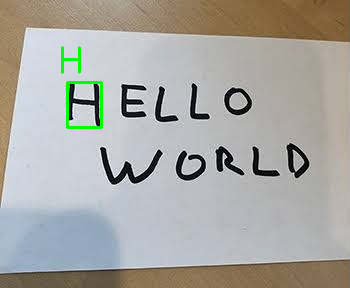

[INFO] W - 89.04%


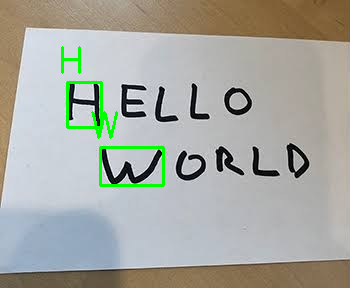

[INFO] E - 90.91%


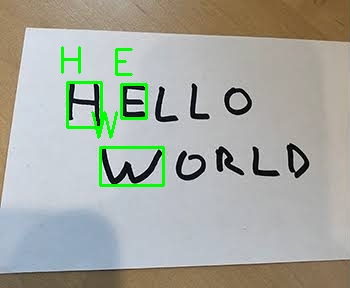

[INFO] 1 - 76.63%


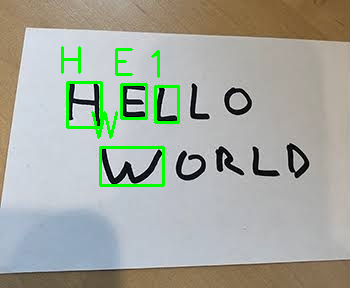

[INFO] 0 - 35.20%


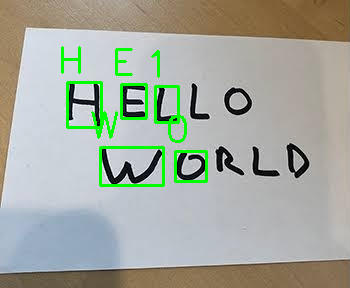

[INFO] 1 - 89.73%


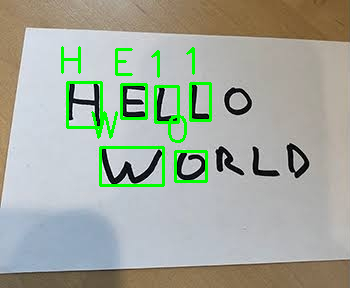

[INFO] R - 94.06%


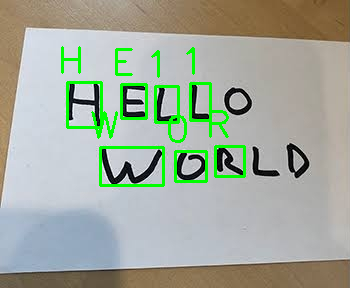

[INFO] 0 - 59.85%


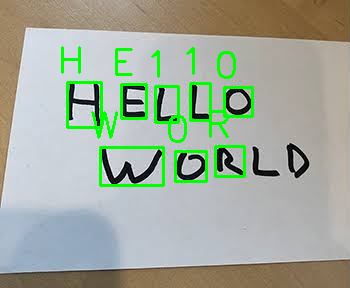

[INFO] L - 97.74%


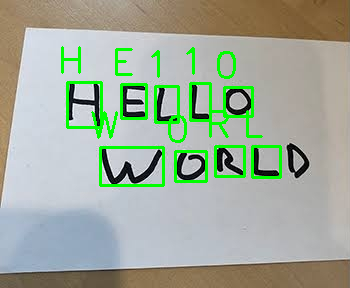

[INFO] D - 88.69%


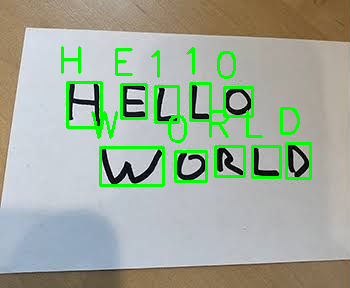

In [30]:
from google.colab.patches import cv2_imshow

# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
	i = np.argmax(pred)
	prob = pred[i]
	label = labelNames[i]
	# draw the prediction on the image
	print("[INFO] {} - {:.2f}%".format(label, prob * 100))
	cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
	cv2.putText(image, label, (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)
	# show the image
	cv2_imshow(image)
	cv2.waitKey(0)